# Imports

In [162]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report
from sklearn.base import BaseEstimator, ClassifierMixin
from catboost import CatBoostClassifier, Pool

In [152]:
pd.set_option('display.max_columns', 500)

# Load data

In [104]:
data = pd.read_csv('../data/clickdata.csv')

data.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,NaN,ANONYMOUS,Robot
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,NaN,ANONYMOUS,Robot
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,NaN,ANONYMOUS,Robot
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,NaN,ANONYMOUS,Robot Mobile


## Preprocess/create features

In [105]:
# Add stratification label
data['stratification'] = data['visitor_recognition_type'] + '_' + data['ua_agent_class']

# Filter out labels with less than min samples
data = data.loc[~data['stratification'].str.contains('RECOGNIZED_Hacker'), :]
data = data.loc[~data['ua_agent_class'].isin(['Cloud Application', 'Mobile App']), :]

# Filling in missing values
data.loc[data['country_by_ip_address'].isna(), 'country_by_ip_address'] = 'UNK'
data.loc[data['region_by_ip_address'].isna(), 'region_by_ip_address'] = 'UNK'
data.loc[data['referrer_without_parameters'].isna(), 'referrer_without_parameters'] = ''

# Splitting class into class and source
data.loc[data['ua_agent_class'] == 'Browser Webview', 'ua_source'] = 'Webview'
data.loc[data['ua_agent_class'] == 'Browser Webview', 'ua_agent_class'] = 'Browser'
data.loc[data['ua_agent_class'] == 'Robot Mobile', 'ua_source'] = 'Mobile'
data.loc[data['ua_agent_class'] == 'Robot Mobile', 'ua_agent_class'] = 'Robot'

data.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class,stratification,ua_source
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,,ANONYMOUS,Robot,ANONYMOUS_Robot,NaN
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,,ANONYMOUS,Robot,ANONYMOUS_Robot,NaN
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser,ANONYMOUS_Browser,NaN
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,,ANONYMOUS,Robot,ANONYMOUS_Robot,NaN
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,,ANONYMOUS,Robot,ANONYMOUS_Robot Mobile,Mobile


## Parse URLs

In [106]:
def parse_url(url, prefix = 'https://www.bol.com/nl/'):
    def is_product_code(x):
        pass

    url_components = url.removeprefix(prefix).split('/')
    row = {
        'url_function': '',
        'category': '',
        'category_id': '',
        'category_filters': [],
        'n_category_filters': 0,
        'attribute_filters': [],
        'n_attribute_filters': 0,
        'search_type': '',
        'search_text': '',
        'search_context': '',
        'Nty': '',
        'product_id': '',
        'other': '',
        'tracking_id': ''
    }

    if url_components[0] == 'c':
        row['url_function'] = url_components[0]

        if url_components[1] == 'ajax':
            row['other'] = url_components[1]

        else:
            row['category'] = url_components[1]

            if url_components[2].isdigit():
                row['category_id'] = url_components[2]

            else:
                row['category'] = row['category'] + '/' + url_components[2]

                if url_components[3].isdigit():
                    row['category_id'] = url_components[3]

        if 'N' in url_components:
            index = url_components.index('N')
            row['category_filters'] = url_components[index + 1].split('+')

        if 'sc' in url_components:
            index = url_components.index('sc')
            row['search_context'] = url_components[index + 1]

        if 'filter_N' in url_components:
            index = url_components.index('filter_N')
            row['attribute_filters'] = url_components[index + 1].split('+')

    elif url_components[0] == 'checkout':
        row['url_function'] = url_components[0]
        row['other'] = url_components[1]

    elif url_components[0] == 'l':
        row['url_function'] = url_components[0]

        if url_components[1] == 'ajax':
            row['other'] = url_components[1]

        else:
            row['category'] = url_components[1]

        if 'N' in url_components:
            index = url_components.index('N')
            row['category_filters'] = url_components[index + 1].split('+')

        if 'filter_N' in url_components:
            index = url_components.index('filter_N')
            row['attribute_filters'] = url_components[index + 1].split('+')

    elif url_components[0] == 'order':
        row['url_function'] = url_components[0]
        row['other'] = url_components[1]

    elif url_components[0] == 'p':
        row['url_function'] = url_components[0]
        row['category'] = url_components[1]

        if url_components[2].isdigit():
            row['product_id'] = url_components[2]

    elif url_components[0] == 's':
        row['url_function'] = url_components[0]

        if url_components[1].isdigit():
            row['category_id'] = url_components[1]
        
        else:
            row['category'] = url_components[1]

        if 'N' in url_components:
            index = url_components.index('N')
            row['category_filters'] = url_components[index + 1].split('+')

        if 'Ntt' in url_components:
            index = url_components.index('Ntt')
            row['search_text'] = url_components[index + 1]

        if 'Nty' in url_components:
            index = url_components.index('Nty')
            row['Nty'] = url_components[index + 1]

        if 'sc' in url_components:
            index = url_components.index('sc')
            row['search_context'] = url_components[index + 1]

        if 'filter_N' in url_components:
            index = url_components.index('filter_N')
            row['attribute_filters'] = url_components[index + 1].split('+')

        if 'ajax' in url_components:
            row['other'] = 'ajax'

    elif url_components[0] == 'w':
        row['url_function'] = url_components[0]

        if url_components[1] == 'ajax':
            row['other'] = url_components[1]

        else:
            row['category'] = url_components[1]

            if url_components[2].isdigit():
                row['tracking_id'] = url_components[2]

            else:
                row['category'] = row['category'] + '/' + url_components[2]
                row['tracking_id'] = url_components[3]

            if 'N' in url_components:
                index = url_components.index('N')
                row['category_filters'] = url_components[index + 1].split('+')

            if 'filter_N' in url_components:
                index = url_components.index('filter_N')
                row['attribute_filters'] = url_components[index + 1].split('+')              

    row['n_category_filters'] = len(row['category_filters'])
    row['n_attribute_filters'] = len(row['attribute_filters'])

    return pd.Series(row)

In [107]:
url_features = ['url_function',
                'category',
                'category_id',
                'category_filters',
                'n_category_filters',
                'attribute_filters',
                'n_attribute_filters',
                'search_type',
                'search_text',
                'search_context',
                'Nty',
                'product_id',
                'other',
                'tracking_id']

data[url_features] = data['url_without_parameters'].apply(lambda url: parse_url(url))

data.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class,stratification,ua_source,...,n_category_filters,attribute_filters,n_attribute_filters,search_type,search_text,search_context,Nty,product_id,other,tracking_id
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,,ANONYMOUS,Robot,ANONYMOUS_Robot,NaN,...,3,[],0,,,,,,,
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,,ANONYMOUS,Robot,ANONYMOUS_Robot,NaN,...,4,[],0,,,,,,,
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser,ANONYMOUS_Browser,NaN,...,0,[],0,,,,,9200000025533140,,
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,,ANONYMOUS,Robot,ANONYMOUS_Robot,NaN,...,6,[4273962351],1,,,,,,,
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,,ANONYMOUS,Robot,ANONYMOUS_Robot Mobile,Mobile,...,3,[],0,,,,,,,


# Base model

In [47]:
X = data[['country_by_ip_address', 'region_by_ip_address', 'visitor_recognition_type']]
y = data['ua_agent_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=data['stratification'], random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=['country_by_ip_address', 'region_by_ip_address', 'visitor_recognition_type'])

clf = CatBoostClassifier(iterations=100)

clf.fit(train_pool, verbose=False)

In [48]:
test_pool = Pool(data=X_test, cat_features=['country_by_ip_address', 'region_by_ip_address', 'visitor_recognition_type'])
y_pred = clf.predict(test_pool)
print(classification_report(y_test, y_pred, labels=clf.classes_, zero_division=0.0))

              precision    recall  f1-score   support

     Browser       0.98      0.99      0.99      9327
      Hacker       0.00      0.00      0.00       294
       Robot       0.95      0.99      0.97      5286
     Special       1.00      0.08      0.15        36

    accuracy                           0.97     14943
   macro avg       0.73      0.52      0.53     14943
weighted avg       0.95      0.97      0.96     14943



## With url_function

In [49]:
X = data[['country_by_ip_address', 'region_by_ip_address', 'visitor_recognition_type', 'url_function']]
y = data['ua_agent_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=data['stratification'], random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=['country_by_ip_address', 'region_by_ip_address', 'visitor_recognition_type', 'url_function'])

clf = CatBoostClassifier(iterations=100)

clf.fit(train_pool, verbose=False)

In [50]:
test_pool = Pool(data=X_test, cat_features=['country_by_ip_address', 'region_by_ip_address', 'visitor_recognition_type', 'url_function'])
y_pred = clf.predict(test_pool)
print(classification_report(y_test, y_pred, labels=clf.classes_, zero_division=0.0))

              precision    recall  f1-score   support

     Browser       0.98      0.99      0.99      9327
      Hacker       0.60      0.03      0.06       294
       Robot       0.96      1.00      0.98      5286
     Special       1.00      0.08      0.15        36

    accuracy                           0.97     14943
   macro avg       0.88      0.53      0.54     14943
weighted avg       0.97      0.97      0.96     14943



# With URL components

In [118]:
features = ['country_by_ip_address', 
            'region_by_ip_address', 
            'visitor_recognition_type',
            'url_function',
            'category',
            'category_id',
            'n_category_filters',
            'n_attribute_filters',
            'search_type',
            'search_text',
            'search_context',
            'Nty',
            'product_id',
            'other',
            'tracking_id']

cat_features = ['country_by_ip_address', 
                'region_by_ip_address', 
                'visitor_recognition_type',
                'url_function',
                'category',
                'category_id',
                'search_type',
                'search_text',
                'search_context',
                'Nty',
                'product_id',
                'other',
                'tracking_id']

X = data[features]
y = data['ua_agent_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=data['stratification'], random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)

clf = CatBoostClassifier(iterations=100)

clf.fit(train_pool, verbose=False)

In [119]:
test_pool = Pool(data=X_test, cat_features=cat_features)
y_pred = clf.predict(test_pool)
print(classification_report(y_test, y_pred, labels=clf.classes_, zero_division=0.0))

              precision    recall  f1-score   support

     Browser       0.99      0.99      0.99      9327
      Hacker       0.92      0.57      0.71       294
       Robot       0.96      0.99      0.98      5286
     Special       1.00      0.11      0.20        36

    accuracy                           0.98     14943
   macro avg       0.97      0.67      0.72     14943
weighted avg       0.98      0.98      0.98     14943



# Hyperparameter tuned

In [ ]:
class CatBoostClassifierWrapper(CatBoostClassifier, BaseEstimator):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def fit(self, X, y, **kwargs):
        # TODO: Parameterize this. 
        cat_features = ['country_by_ip_address', 
                        'region_by_ip_address', 
                        'visitor_recognition_type',
                        'url_function',
                        'category',
                        'category_id',
                        'search_type',
                        'search_text',
                        'search_context',
                        'Nty',
                        'product_id',
                        'other',
                        'tracking_id']

        pool = Pool(data=X, label=y, cat_features=cat_features)
        return super().fit(pool, **kwargs)

In [138]:
features = ['country_by_ip_address', 
            'region_by_ip_address', 
            'visitor_recognition_type',
            'url_function',
            'category',
            'category_id',
            'n_category_filters',
            'n_attribute_filters',
            'search_type',
            'search_text',
            'search_context',
            'Nty',
            'product_id',
            'other',
            'tracking_id']

cat_features = ['country_by_ip_address', 
                'region_by_ip_address', 
                'visitor_recognition_type',
                'url_function',
                'category',
                'category_id',
                'search_type',
                'search_text',
                'search_context',
                'Nty',
                'product_id',
                'other',
                'tracking_id']

X = data[features]
y = data['ua_agent_class']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter search space
param_dist = {
    # Learning rate and trees
    # "iterations": [100, 300, 500, 1000],           # number of boosting rounds
    "learning_rate": [0.01, 0.05, 0.1, 0.2],      # step size shrinkage
    
    # Tree structure
    # "depth": [4, 6, 8, 10],

    # # Sampling
    # "border_count": np.arange(32, 256, 32),           # number of splits for numerical features
    # "bagging_temperature": np.linspace(0, 1, 10),     # controls sampling intensity for bagging
    # "random_strength": np.linspace(0, 1, 10),         # randomness for score calculation
    # "rsm": np.linspace(0.5, 1, 6),                     # random subspace method, feature fraction

    # "l2_leaf_reg": [0.1, 0.5, 1, 5, 10],             # L2
    # # "scale_pos_weight": [1, 2, 5, 10],                 # useful if classes are imbalanced
}

# TODO: Causes an error. Needs custom implementation
# Required for stratification on multi-column ua_agent_class + visitor_recognition_type
# cv_splitter = skf.split(X, data['stratification'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=data['stratification'], random_state=42)

scoring = {
    "f1_macro": make_scorer(f1_score, average="macro"),
    "f1_weighted": make_scorer(f1_score, average="weighted")
}

clf = CatBoostClassifierWrapper(iterations=500,
                                verbose=0, 
                                random_seed=42)

search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=1000,
    scoring=scoring,
    refit='f1_macro',
    cv=skf,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

search_results = search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/tusharpal/anaconda3/envs/bol/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=1000. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END .................................learning_rate=0.01; total time=10.4min
[CV] END .................................learning_rate=0.01; total time=10.7min
[CV] END .................................learning_rate=0.01; total time=10.8min
[CV] END .................................learning_rate=0.01; total time=11.0min
[CV] END .................................learning_rate=0.01; total time=11.0min
[CV] END .................................learning_rate=0.05; total time=12.5min
[CV] END .................................learning_rate=0.05; total time=12.6min
[CV] END .................................learning_rate=0.05; total time=12.6min
[CV] END ..................................learning_rate=0.1; total time=12.7min
[CV] END .................................learning_rate=0.05; total time=12.8min
[CV] END ..................................learning_rate=0.1; total time=12.8min
[CV] END .................................learning_rate=0.05; total time=12.9min
[CV] END ...................

In [ ]:
# joblib.dump(search, '../checkpoints/Catboost/search/learning_rate_500.pkl')

['../checkpoints/Catboost/search/learning_rate_500.pkl']

## Learning rates and iterations

In [160]:
cv_results = []

for iteration in [100, 300, 500]:
    t = joblib.load(f"../checkpoints/Catboost/search/learning_rate_{iteration}.pkl")
    t = pd.DataFrame.from_dict(t.cv_results_)
    t['param_iterations'] = iteration

    cv_results.append(t)

cv_results = pd.concat(cv_results).sort_values('mean_test_f1_macro', ascending=False)

cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,param_iterations
2,766.931563,7.699912,3.127223,2.122454,0.10,{'learning_rate': 0.1},0.787742,0.701726,0.726379,0.748095,0.661872,0.725163,0.042423,1,0.982568,0.980560,0.978417,0.981067,0.979597,0.980442,0.001396,2,500
3,705.383673,42.148331,0.651941,0.387505,0.20,{'learning_rate': 0.2},0.786576,0.702233,0.724774,0.746776,0.664939,0.725059,0.040967,2,0.982313,0.980543,0.978455,0.980859,0.980047,0.980443,0.001248,1,500
3,310.289817,2.470518,1.674727,0.918936,0.20,{'learning_rate': 0.2},0.787121,0.702233,0.726398,0.746545,0.659539,0.724367,0.042724,1,0.982198,0.980543,0.978261,0.980731,0.979368,0.980220,0.001330,1,300
1,753.163977,8.307144,6.765117,1.027139,0.05,{'learning_rate': 0.05},0.785650,0.704689,0.727274,0.747189,0.656295,0.724219,0.043141,3,0.982138,0.980892,0.978373,0.980833,0.978585,0.980164,0.001454,3,500
2,311.950485,7.212091,3.168819,0.995941,0.10,{'learning_rate': 0.1},0.786146,0.700413,0.729534,0.747310,0.653471,0.723375,0.044643,2,0.982282,0.980296,0.978825,0.980897,0.978521,0.980164,0.001381,2,300


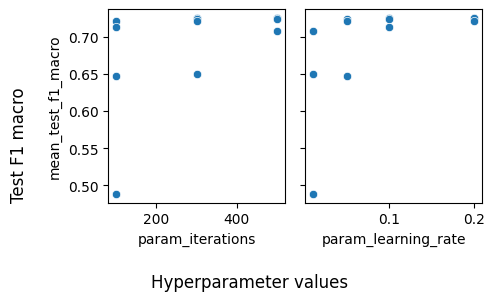

In [164]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(5, 3), tight_layout=False)

for i, col in enumerate(['param_iterations', 'param_learning_rate']):
    sns.scatterplot(pd.DataFrame(cv_results), 
                    x=col, 
                    y='mean_test_f1_macro', 
                    ax=ax[i])
    ax[i].set_xlabel(col)

fig.supxlabel('Hyperparameter values')
fig.supylabel('Test F1 macro')

plt.show()

## Depth

In [174]:
t = joblib.load(f"../checkpoints/Catboost/search/depth.pkl")
cv_results = pd.DataFrame.from_dict(t.cv_results_).sort_values('mean_test_f1_macro', ascending=False)

cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
3,55.791798,3.772821,0.280615,0.114003,10,{'depth': 10},0.782536,0.701549,0.722744,0.745346,0.662978,0.723031,0.040266,1,0.981304,0.980431,0.977363,0.979459,0.980257,0.979763,0.001336,1
1,38.304795,0.371713,0.672613,0.061498,6,{'depth': 6},0.777538,0.701176,0.725161,0.738639,0.657711,0.720045,0.039797,2,0.980973,0.978890,0.977445,0.978412,0.979007,0.978945,0.001154,3
0,26.274784,0.230911,0.512470,0.077859,4,{'depth': 4},0.774363,0.699398,0.721672,0.745238,0.652075,0.718549,0.041528,3,0.980297,0.979237,0.976744,0.979395,0.977823,0.978699,0.001258,4
2,49.010422,1.709464,0.868444,0.324992,8,{'depth': 8},0.781357,0.698550,0.690120,0.744506,0.662541,0.715415,0.042224,4,0.981314,0.979933,0.977696,0.978852,0.979952,0.979549,0.001212,2


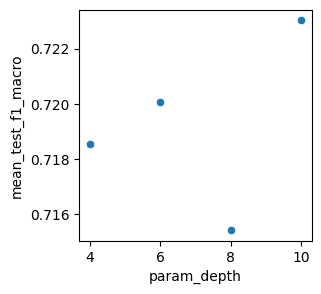

In [167]:
plt.figure(figsize=(3, 3))

sns.scatterplot(cv_results, 
                x='param_depth', 
                y='mean_test_f1_macro')

plt.xlabel('param_depth')
fig.supylabel('Test F1 macro')

plt.show()

## bagging_temperature

In [175]:
t = joblib.load(f"../checkpoints/Catboost/search/bagging_temperature.pkl")
cv_results = pd.DataFrame.from_dict(t.cv_results_).sort_values('mean_test_f1_macro', ascending=False)

cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bagging_temperature,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
2,45.297612,6.908979,0.682140,0.328590,0.222222,{'bagging_temperature': 0.2222222222222222},0.779453,0.701058,0.722702,0.742146,0.684932,0.726058,0.032977,1,0.981177,0.980548,0.977178,0.978735,0.980015,0.979531,0.001425,1
0,36.489603,0.281856,0.464991,0.085910,0.000000,{'bagging_temperature': 0.0},0.776344,0.702165,0.721061,0.747109,0.683120,0.725960,0.032898,2,0.980565,0.980534,0.976425,0.979594,0.979770,0.979378,0.001527,4
1,36.692397,0.443223,0.384462,0.142155,0.111111,{'bagging_temperature': 0.1111111111111111},0.776808,0.698029,0.719529,0.750209,0.680651,0.725045,0.034767,3,0.981114,0.979947,0.976584,0.980211,0.979353,0.979442,0.001538,2
4,54.097040,0.712422,1.048763,0.194281,0.444444,{'bagging_temperature': 0.4444444444444444},0.781358,0.699895,0.715172,0.746151,0.682377,0.724991,0.035120,4,0.981316,0.979323,0.976075,0.979585,0.979497,0.979159,0.001702,5
8,65.835663,0.429005,1.186765,0.534358,0.888889,{'bagging_temperature': 0.8888888888888888},0.782355,0.701943,0.724474,0.744159,0.654602,0.721507,0.042623,5,0.981451,0.980131,0.977873,0.979112,0.978554,0.979424,0.001255,3


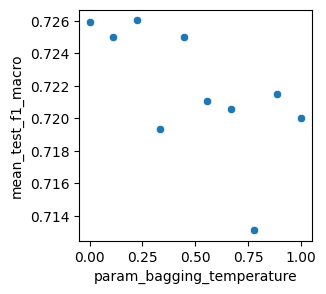

In [169]:
plt.figure(figsize=(3, 3))

sns.scatterplot(cv_results, 
                x='param_bagging_temperature', 
                y='mean_test_f1_macro')

plt.xlabel('param_bagging_temperature')
fig.supylabel('Test F1 macro')

plt.show()

## rsm

In [176]:
t = joblib.load(f"../checkpoints/Catboost/search/rsm.pkl")
cv_results = pd.DataFrame.from_dict(t.cv_results_).sort_values('mean_test_f1_macro', ascending=False)

cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rsm,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
3,31.778483,0.306276,0.649994,0.127097,0.8,{'rsm': 0.8},0.793803,0.696354,0.720318,0.742027,0.662051,0.722911,0.044288,1,0.981102,0.978678,0.976742,0.978517,0.979712,0.978950,0.001439,4
2,26.323879,2.752040,0.452562,0.150995,0.7,{'rsm': 0.7},0.780057,0.699116,0.727217,0.742771,0.660269,0.721886,0.040407,2,0.981169,0.978949,0.978294,0.978822,0.978712,0.979189,0.001014,1
1,22.290023,0.116983,0.254491,0.009154,0.6,{'rsm': 0.6},0.778247,0.704218,0.721665,0.745304,0.655709,0.721029,0.041019,3,0.980921,0.979395,0.977097,0.979351,0.978471,0.979047,0.001254,3
0,21.151916,0.130634,0.443406,0.057675,0.5,{'rsm': 0.5},0.776134,0.700725,0.727393,0.739101,0.661401,0.720951,0.038396,4,0.980540,0.979019,0.978471,0.978283,0.979560,0.979175,0.000816,2
5,21.207777,1.210610,0.217826,0.087805,1.0,{'rsm': 1.0},0.777538,0.701176,0.725161,0.738639,0.657711,0.720045,0.039797,5,0.980973,0.978890,0.977445,0.978412,0.979007,0.978945,0.001154,5


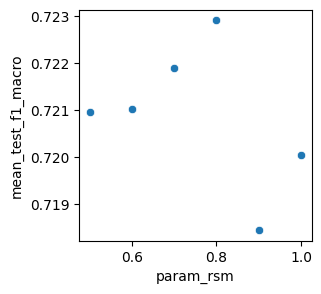

In [171]:
plt.figure(figsize=(3, 3))

sns.scatterplot(cv_results, 
                x='param_rsm', 
                y='mean_test_f1_macro')

plt.xlabel('param_rsm')
fig.supylabel('Test F1 macro')

plt.show()

## l2_leaf_reg

In [177]:
t = joblib.load(f"../checkpoints/Catboost/search/l2_leaf_reg.pkl")
cv_results = pd.DataFrame.from_dict(t.cv_results_).sort_values('mean_test_f1_macro', ascending=False)

cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l2_leaf_reg,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,33.568399,0.403416,0.449185,0.209677,0.1,{'l2_leaf_reg': 0.1},0.650851,0.632622,0.629402,0.644515,0.639695,0.639417,0.007788,1,0.975154,0.974050,0.972642,0.973941,0.976288,0.974415,0.001229,1
2,44.353267,8.708593,0.960465,0.506819,1.0,{'l2_leaf_reg': 1},0.650134,0.628766,0.630089,0.647202,0.635545,0.638347,0.008777,2,0.975157,0.973649,0.972966,0.974254,0.975153,0.974236,0.000854,3
1,33.490099,0.484354,0.464467,0.193922,0.5,{'l2_leaf_reg': 0.5},0.650240,0.628766,0.630027,0.647450,0.634963,0.638289,0.008908,3,0.975215,0.973649,0.972854,0.974701,0.975536,0.974391,0.001000,2
4,43.783249,17.874392,0.390129,0.135503,10.0,{'l2_leaf_reg': 10},0.640349,0.628995,0.629120,0.644411,0.636025,0.635780,0.006096,4,0.973987,0.973671,0.972676,0.973989,0.975032,0.973871,0.000754,4
3,53.139021,0.357375,0.755162,0.159136,5.0,{'l2_leaf_reg': 5},0.648163,0.624415,0.630826,0.635396,0.633751,0.634510,0.007788,5,0.974898,0.973265,0.972803,0.972921,0.974806,0.973739,0.000922,5


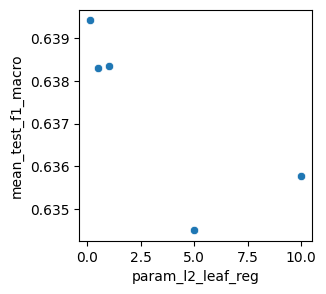

In [173]:
plt.figure(figsize=(3, 3))

sns.scatterplot(cv_results, 
                x='param_l2_leaf_reg', 
                y='mean_test_f1_macro')

plt.xlabel('param_l2_leaf_reg')
fig.supylabel('Test F1 macro')

plt.show()

# Aggregate of all searches
With the best hyperparameters

In [178]:
features = ['country_by_ip_address', 
            'region_by_ip_address', 
            'visitor_recognition_type',
            'url_function',
            'category',
            'category_id',
            'n_category_filters',
            'n_attribute_filters',
            'search_type',
            'search_text',
            'search_context',
            'Nty',
            'product_id',
            'other',
            'tracking_id']

cat_features = ['country_by_ip_address', 
                'region_by_ip_address', 
                'visitor_recognition_type',
                'url_function',
                'category',
                'category_id',
                'search_type',
                'search_text',
                'search_context',
                'Nty',
                'product_id',
                'other',
                'tracking_id']

X = data[features]
y = data['ua_agent_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=data['stratification'], random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)

params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'depth': 10,
    'bagging_temperature': 0.22,
    'rsm': 0.8,
    'l2_leaf_reg': 0.1
}

clf = CatBoostClassifier(**params)

clf.fit(train_pool, verbose=False)

In [179]:
test_pool = Pool(data=X_test, cat_features=cat_features)
y_pred = clf.predict(test_pool)
print(classification_report(y_test, y_pred, labels=clf.classes_, zero_division=0.0))

              precision    recall  f1-score   support

     Browser       0.99      0.99      0.99      9327
      Hacker       0.89      0.63      0.74       294
       Robot       0.97      0.99      0.98      5286
     Special       0.23      0.14      0.17        36

    accuracy                           0.98     14943
   macro avg       0.77      0.69      0.72     14943
weighted avg       0.98      0.98      0.98     14943

